In [25]:
import matplotlib as mpl
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from scipy.stats import norm, mannwhitneyu

In [26]:
exp_root = "/media/yesindeed/DATADRIVE1/mount/remote_cse/experiments/med_vlm_benchmark/merged"

df_results = pd.read_csv(os.path.join(exp_root, "results.csv"))

df_results

,model,task,dataset,model_type,trainable_module,path,have_eval_result,have_prediction,have_gpt_score,model_name,...,exact_match_overall,recall_overall,precision_overall,f1_overall,exact_match_closed,recall_closed,precision_closed,f1_score_closed,accuracy_closed,gpt_score_open
0,Qwen2-VL,vqa,SLAKE,general,NaN,vqa/SLAKE/Qwen2-VL/eval_seed0/Qwen2-VL-7B-Inst...,1,1,0,Qwen2-VL-7B-Instruct,...,0.285276,0.624306,0.292802,0.318349,0.658153,0.774038,0.661506,0.668063,0.778846,NaN
1,Qwen25-VL,vqa,SLAKE,general,NaN,vqa/SLAKE/Qwen25-VL/eval_seed0/Qwen2.5-VL-7B-I...,1,1,0,Qwen2.5-VL-7B-Instruct,...,0.252990,0.596551,0.260487,0.274167,0.627367,0.747596,0.629623,0.633801,0.754808,NaN
2,Gemma3,vqa,SLAKE,general,NaN,vqa/SLAKE/Gemma3/eval_seed0/gemma-3-4b-it,1,1,0,gemma-3-4b-it,...,0.032464,0.525746,0.038177,0.056352,0.070822,0.657252,0.073086,0.097527,0.721154,NaN
3,MedGemma,vqa,SLAKE,medical,NaN,vqa/SLAKE/MedGemma/eval_seed0/medgemma-4b-it,1,1,0,medgemma-4b-it,...,0.243252,0.575250,0.250568,0.265892,0.597256,0.725962,0.599219,0.604106,0.769231,NaN
4,InternVL3,vqa,SLAKE,general,NaN,vqa/SLAKE/InternVL3/eval_seed0/InternVL3-8B-hf,1,1,0,InternVL3-8B-hf,...,0.093509,0.601884,0.102192,0.128382,0.209306,0.711538,0.212497,0.238663,0.745192,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,VILA,vqa,VQA-RAD,general,ML,vqa/VQA-RAD/VILA1.5/eval_seed0/1epoch-lora8,1,1,1,train_lora_ML_seed42_vila,...,0.485218,0.470030,0.485218,0.472669,0.637450,0.637450,0.637450,0.637450,0.637450,44.820000
69,VILA-M3,vqa,VQA-RAD,medical,ML,vqa/VQA-RAD/VILA-M3/eval_seed0/1epoch-lora8,1,1,1,train_lora_ML_seed42_vila_m3,...,0.370001,0.420918,0.370242,0.379170,0.537849,0.537849,0.537849,0.537849,0.537849,46.795000
70,Lingshu,vqa,Harvard-FairVLMed10k,medical,ML,vqa/Harvard-FairVLMed10k/Lingshu/eval_seed0/1e...,1,1,1,train_lora_ML_seed42_lingshu,...,0.576751,0.591223,0.580907,0.580271,0.738978,0.738978,0.738978,0.738978,0.738978,57.234234
71,VILA,vqa,Harvard-FairVLMed10k,general,ML,vqa/Harvard-FairVLMed10k/VILA1.5/eval_seed0/1e...,1,1,1,train_lora_ML_seed42_vila,...,0.662567,0.638053,0.668046,0.647041,0.811122,0.811122,0.811122,0.811122,0.811122,56.039540


In [27]:
def find_order(df, order=1, dataset=None, model_type=None, metric="accuracy_closed"):
    if dataset is not None:
        df = df.loc[df["dataset"] == dataset]
    if model_type is not None:
        df = df.loc[df["model_type"] == model_type]

    # return df.sort_values(by=metric).head()
    df_sub = df.nlargest(order, metric).reset_index(drop=True)
    return df_sub.tail(1).reset_index(drop=True)

In [28]:
df_zs = df_results.loc[df_results["trainable_module"] != "ML"].reset_index(drop=True)
df_tuned = df_results.loc[df_results["trainable_module"] == "ML"].reset_index(drop=True)

In [31]:
from scipy import stats

metric = "accuracy_closed"


def paired_ttest(df_compare, df_baseline_strict, df_baseline_relax):
    path_baseline_strict = os.path.join(
        exp_root, df_baseline_strict["path"].tolist()[0])
    path_baseline_relax = os.path.join(
        exp_root, df_baseline_relax["path"].tolist()[0])

    df_each_case_strict = pd.read_csv(os.path.join(
        path_baseline_strict, "each_example_result.csv"))
    df_each_case_relax = pd.read_csv(os.path.join(
        path_baseline_relax, "each_example_result.csv"))

    df_each_case_strict = df_each_case_strict.loc[df_each_case_strict["question_type"] == "closed"]
    df_each_case_relax = df_each_case_relax.loc[df_each_case_relax["question_type"] == "closed"]

    results_each_case_strict = np.array(df_each_case_strict[metric])
    results_each_case_relax = np.array(df_each_case_relax[metric])

    p_strict_dict = {}
    p_relax_dict = {}

    for i_compare in range(len(df_compare)):
        item = df_compare.iloc[i_compare]
        model = item["model"]

        df_each_case_compare = pd.read_csv(os.path.join(
            exp_root, item["path"], "each_example_result.csv"))
        df_each_case_compare = df_each_case_compare.loc[df_each_case_compare["question_type"] == "closed"]

        results_each_case_compare = np.array(df_each_case_compare[metric])

        t_stat_strict, p_strict = stats.ttest_rel(
            results_each_case_compare, results_each_case_strict, alternative="greater"
        )
        t_stat_relax, p_relax = stats.ttest_rel(
            results_each_case_compare, results_each_case_relax, alternative="greater"
        )

        p_strict_dict[model] = p_strict
        p_relax_dict[model] = p_relax

    return p_strict_dict, p_relax_dict


def plot_ptest(df_plot, rq):
    plt.figure()
    sns.histplot(
        data=df_plot.loc[df_plot["mode"] == "strict"],
        y="dataset",
        # y="value",
        hue="range",
        hue_order=[
            "Significantly Better (p < 0.05)",
            "No Significant Difference (0.05 < p < 0.95)",
            "Significantly Worse (p > 0.95)",
        ],
        multiple="fill",
        stat="percent",
        shrink=0.4,
        palette=[
            "#1F78B4",
            "#A6CEE3",
            "#B2DF8A",
            # "#FB9A99",
        ],
        # weights=0.5,
    )
    plt.savefig(f"compare_ptest/{rq}_strict.png")

    plt.figure()
    sns.histplot(
        data=df_plot.loc[df_plot["mode"] == "relax"],
        y="dataset",
        # y="value",
        hue="range",
        hue_order=[
            "Significantly Better (p < 0.05)",
            "No Significant Difference (0.05 < p < 0.95)",
            "Significantly Worse (p > 0.95)",
        ],
        multiple="fill",
        stat="percent",
        shrink=0.4,
        palette=[
            "#FF7F00",
            "#FDBF6F",
            "#FB9A99",
        ],
        # weights=0.5,
    )
    plt.savefig(f"compare_ptest/{rq}_relax.png")

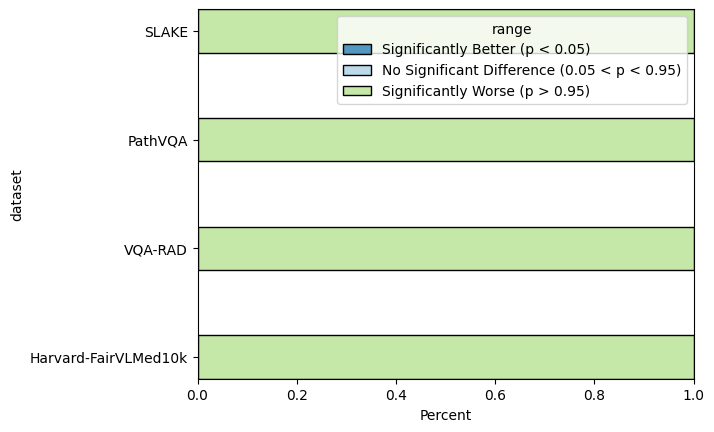

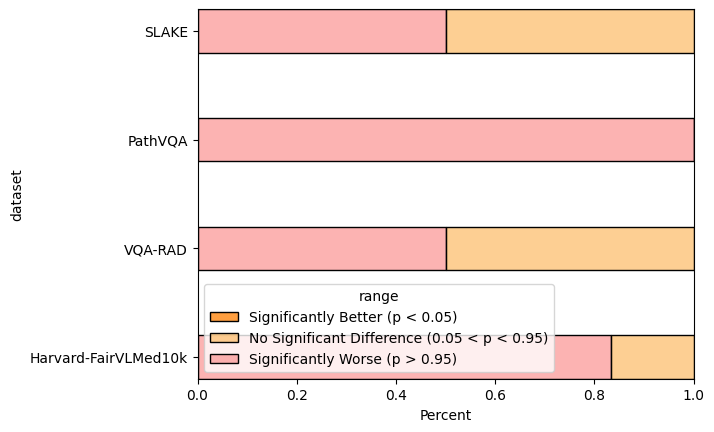

In [32]:
# RQ1
datasets = {
    "SLAKE": "/research/d5/gds/yzhong22/datasets/SLAKE/imgs",
    "PathVQA": "None",
    "VQA-RAD": "None",
    "Harvard-FairVLMed10k": "/research/d5/gds/yzhong22/datasets/Harvard-FairVLMed10k",
}

stats_plot = []

for data in datasets.keys():
    df_compare = df_zs.loc[(df_zs["dataset"] == data) & (
        df_zs["model_type"] == "general")].reset_index(drop=True)
    df_baseline_strict = find_order(
        df_zs, order=1, dataset=data, model_type="medical")
    df_baseline_relax = find_order(
        df_zs, order=2, dataset=data, model_type="medical")

    p_strict_dict, p_relax_dict = paired_ttest(
        df_compare, df_baseline_strict, df_baseline_relax)

    # stats_plot.extend(
    #     [
    #         {
    #             "dataset": data,
    #             "mode": "strict",
    #             "range": "Significantly Better (p < 0.05)",
    #             "value": np.sum([1 if x < 0.05 else 0 for x in p_strict_dict.values()]) / len(p_strict_dict),
    #         },
    #         {
    #             "dataset": data,
    #             "mode": "strict",
    #             "range": "No Significant Difference (0.05 < p < 0.95)",
    #             "value": np.sum([1 if (x > 0.05) & (x < 0.95) else 0 for x in p_strict_dict.values()])
    #             / len(p_strict_dict),
    #         },
    #         {
    #             "dataset": data,
    #             "mode": "strict",
    #             "range": "Significantly Worse (p > 0.95)",
    #             "value": np.sum([1 if x > 0.95 else 0 for x in p_strict_dict.values()]) / len(p_strict_dict),
    #         },
    #         {
    #             "dataset": data,
    #             "mode": "relax",
    #             "range": "Significantly Better (p < 0.05)",
    #             "value": np.sum([1 if x < 0.05 else 0 for x in p_relax_dict.values()]) / len(p_relax_dict),
    #         },
    #         {
    #             "dataset": data,
    #             "mode": "relax",
    #             "range": "No Significant Difference (0.05 < p < 0.95)",
    #             "value": np.sum([1 if (x > 0.05) & (x < 0.95) else 0 for x in p_relax_dict.values()])
    #             / len(p_relax_dict),
    #         },
    #         {
    #             "dataset": data,
    #             "mode": "relax",
    #             "range": "Significantly Worse (p > 0.95)",
    #             "value": np.sum([1 if x > 0.95 else 0 for x in p_relax_dict.values()]) / len(p_relax_dict),
    #         },
    #     ]
    # )
    for k, v in p_strict_dict.items():
        if v < 0.05:
            range_ = "Significantly Better (p < 0.05)"
        elif v < 0.95:
            range_ = "No Significant Difference (0.05 < p < 0.95)"
        elif v < 1:
            range_ = "Significantly Worse (p > 0.95)"

        stats_plot.append({"dataset": data, "mode": "strict",
                          "model": k, "range": range_})

    for k, v in p_relax_dict.items():
        if v < 0.05:
            range_ = "Significantly Better (p < 0.05)"
        elif v < 0.95:
            range_ = "No Significant Difference (0.05 < p < 0.95)"
        elif v < 1:
            range_ = "Significantly Worse (p > 0.95)"

        stats_plot.append({"dataset": data, "mode": "relax",
                          "model": k, "range": range_})

df_plot = pd.DataFrame(stats_plot)

plot_ptest(df_plot, "RQ1")

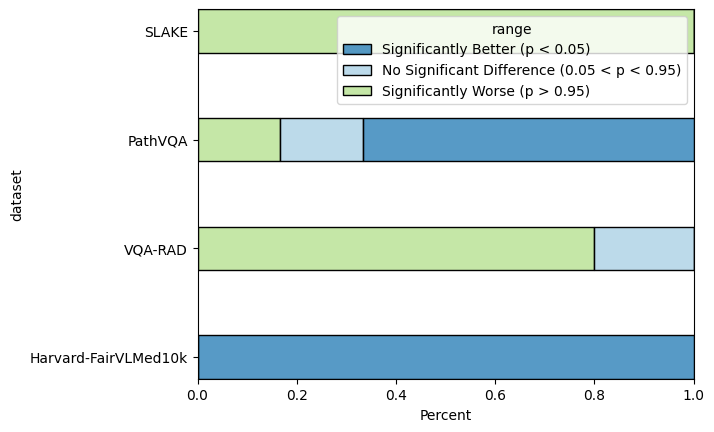

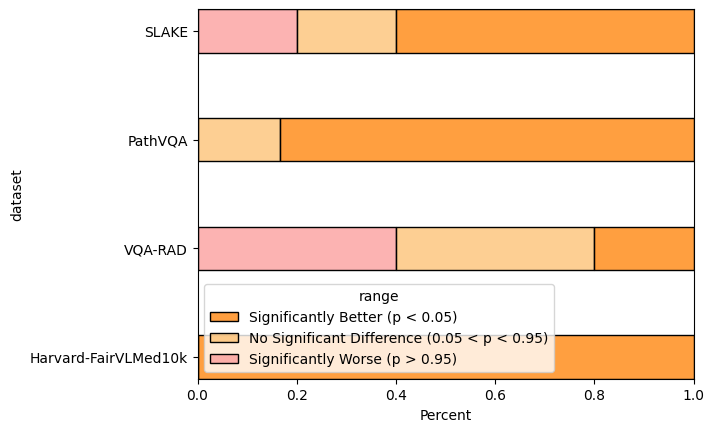

In [34]:
# RQ2
datasets = {
    "SLAKE": "/research/d5/gds/yzhong22/datasets/SLAKE/imgs",
    "PathVQA": "None",
    "VQA-RAD": "None",
    "Harvard-FairVLMed10k": "/research/d5/gds/yzhong22/datasets/Harvard-FairVLMed10k",
}

stats_plot = []
for data in datasets.keys():
    df_compare = df_tuned.loc[(df_tuned["dataset"] == data) & (df_tuned["model_type"] == "general")].reset_index(
        drop=True
    )
    df_baseline_strict = find_order(df_zs, order=1, dataset=data, model_type="medical")
    df_baseline_relax = find_order(df_zs, order=2, dataset=data, model_type="medical")

    p_strict_dict, p_relax_dict = paired_ttest(df_compare, df_baseline_strict, df_baseline_relax)

    for k, v in p_strict_dict.items():
        if v < 0.05:
            range_ = "Significantly Better (p < 0.05)"
        elif v < 0.95:
            range_ = "No Significant Difference (0.05 < p < 0.95)"
        elif v < 1:
            range_ = "Significantly Worse (p > 0.95)"

        stats_plot.append({"dataset": data, "mode": "strict", "model": k, "range": range_})

    for k, v in p_relax_dict.items():
        if v < 0.05:
            range_ = "Significantly Better (p < 0.05)"
        elif v < 0.95:
            range_ = "No Significant Difference (0.05 < p < 0.95)"
        elif v < 1:
            range_ = "Significantly Worse (p > 0.95)"

        stats_plot.append({"dataset": data, "mode": "relax", "model": k, "range": range_})


df_plot = pd.DataFrame(stats_plot)


plot_ptest(df_plot, "RQ2")

In [67]:
tips = sns.load_dataset("tips")
tips

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


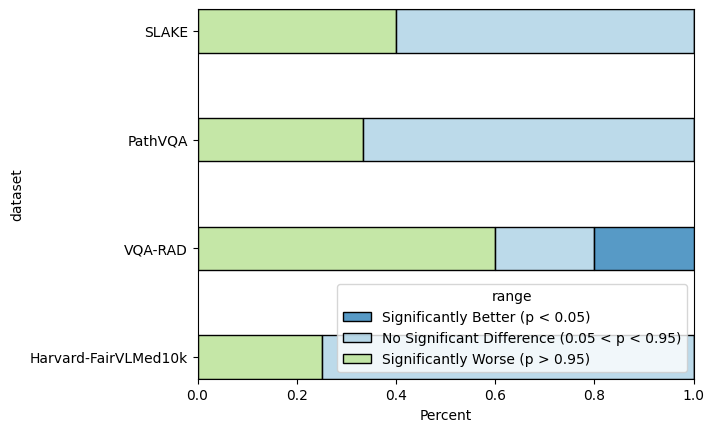

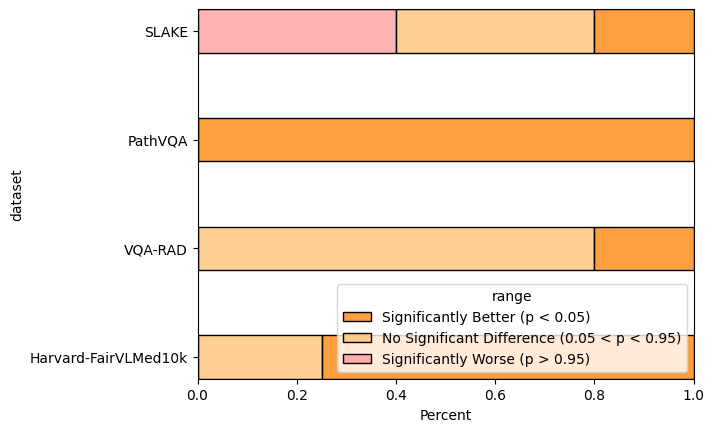

In [36]:
# RQ3
datasets = {
    "SLAKE": "/research/d5/gds/yzhong22/datasets/SLAKE/imgs",
    "PathVQA": "None",
    "VQA-RAD": "None",
    "Harvard-FairVLMed10k": "/research/d5/gds/yzhong22/datasets/Harvard-FairVLMed10k",
}

stats_plot = []
for data in datasets.keys():
    df_compare = df_tuned.loc[(df_tuned["dataset"] == data) & (df_tuned["model_type"] == "general")].reset_index(
        drop=True
    )
    df_baseline_strict = find_order(df_tuned, order=1, dataset=data, model_type="medical")
    df_baseline_relax = find_order(df_tuned, order=2, dataset=data, model_type="medical")

    p_strict_dict, p_relax_dict = paired_ttest(df_compare, df_baseline_strict, df_baseline_relax)

    for k, v in p_strict_dict.items():
        if v < 0.05:
            range_ = "Significantly Better (p < 0.05)"
        elif v < 0.95:
            range_ = "No Significant Difference (0.05 < p < 0.95)"
        elif v < 1:
            range_ = "Significantly Worse (p > 0.95)"

        stats_plot.append({"dataset": data, "mode": "strict", "model": k, "range": range_})

    for k, v in p_relax_dict.items():
        if v < 0.05:
            range_ = "Significantly Better (p < 0.05)"
        elif v < 0.95:
            range_ = "No Significant Difference (0.05 < p < 0.95)"
        elif v < 1:
            range_ = "Significantly Worse (p > 0.95)"

        stats_plot.append({"dataset": data, "mode": "relax", "model": k, "range": range_})

df_plot = pd.DataFrame(stats_plot)

plot_ptest(df_plot, "RQ3")